# Demos: Lecture 15

## Demo 1: Variational Quantum Classifier

In [53]:
import pennylane as qml
from pennylane import numpy as np
from lecture14_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

In [4]:
test_X, test_y = make_blobs(
    n_samples=50, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=50
)

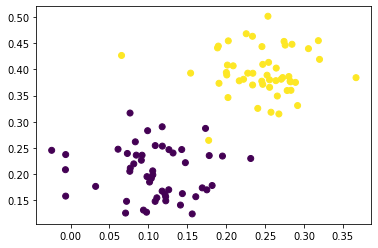

In [3]:
plot_data(X, y)

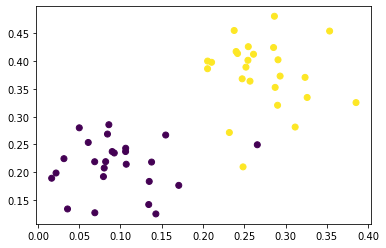

In [5]:
plot_data(test_X, test_y)

In [6]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1
test_y[test_y == 0] = -1

### VQC model 1: amplitude embedding

<img src="fig/model1.png" width="500px">

In [7]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def model_1(point, weights):
    qml.AmplitudeEmbedding(point, wires=0, normalize=True)
    
    qml.Rot(*weights, wires=0)
    
    return qml.expval(qml.PauliZ(0))

In [8]:
weights = np.random.normal(size=3)

In [9]:
weights

tensor([-0.13018781, -0.81780807,  1.73051731], requires_grad=True)

In [10]:
def loss(weights):
    loss_sum = 0.0
    
    for idx in range(n_samples):
        point = X[idx]
        true_expval = y[idx]
        
        estimated_expval = model_1(point, weights)
        loss_sum += (estimated_expval - true_expval) ** 2
        
    return loss_sum / n_samples

In [11]:
our_preds = make_predictions(X, model_1, weights)

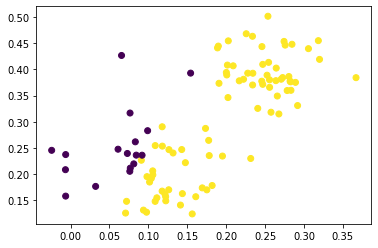

In [12]:
plot_data(X, our_preds)

In [13]:
compute_accuracy(y, our_preds)

0.63

In [14]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 60

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_1, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 0 = 1.040209392981629  Accuracy = 0.65
Loss at iteration 5 = 0.9914735009568152  Accuracy = 0.64
Loss at iteration 10 = 0.9827561824973858  Accuracy = 0.61
Loss at iteration 15 = 0.981315236200353  Accuracy = 0.64
Loss at iteration 20 = 0.9810756514268313  Accuracy = 0.63
Loss at iteration 25 = 0.9810304095309234  Accuracy = 0.64
Loss at iteration 30 = 0.9810163390777197  Accuracy = 0.64
Loss at iteration 35 = 0.981007122525018  Accuracy = 0.64
Loss at iteration 40 = 0.9809985134705521  Accuracy = 0.64
Loss at iteration 45 = 0.98098982193605  Accuracy = 0.64
Loss at iteration 50 = 0.9809809313815235  Accuracy = 0.64
Loss at iteration 55 = 0.9809718178392666  Accuracy = 0.64


In [15]:
our_preds = make_predictions(X, model_1, weights)

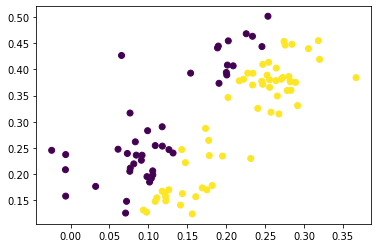

In [16]:
plot_data(X, our_preds)

In [17]:
compute_accuracy(our_preds, y)

0.64

In [18]:
test_preds = make_predictions(test_X, model_1, weights)

In [19]:
compute_accuracy(test_preds, test_y)

0.78

### VQC model 2: angle embedding

<img src="fig/model2.png" width="500px">

In [26]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    # Encoding
    qml.AngleEmbedding(point, wires=range(2))
    
    # Trainable layers
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    
    # Measure
    return qml.expval(qml.PauliX(wires=0))

In [21]:
weights = np.random.normal(size=(2, 3))

In [22]:
weights

tensor([[-0.33198058, -1.05453369, -0.41808035],
        [-0.66381969, -0.21608217, -1.36120774]], requires_grad=True)

In [27]:
model_2(X[0], weights)

tensor(-0.85170882, requires_grad=True)

In [29]:
our_preds = make_predictions(X, model_2, weights)

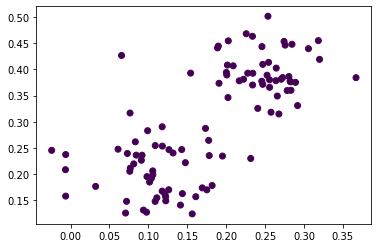

In [31]:
plot_data(X, our_preds)

In [33]:
loss = make_loss_function(X, y, model_2)

In [35]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_2, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 5 = 1.4376453556563666  Accuracy = 0.5
Loss at iteration 10 = 1.1901050520989653  Accuracy = 0.5
Loss at iteration 15 = 1.0860544921967459  Accuracy = 0.5
Loss at iteration 20 = 1.048301082629276  Accuracy = 0.45
Loss at iteration 25 = 1.0267033918476434  Accuracy = 0.13
Loss at iteration 30 = 1.0076694725433657  Accuracy = 0.5
Loss at iteration 35 = 0.9892425651990949  Accuracy = 0.61
Loss at iteration 40 = 0.9716707015654508  Accuracy = 0.85
Loss at iteration 45 = 0.9554171157495113  Accuracy = 0.89
Loss at iteration 50 = 0.9408169681051194  Accuracy = 0.89
Loss at iteration 55 = 0.9280341777796752  Accuracy = 0.91
Loss at iteration 60 = 0.9170832551587306  Accuracy = 0.91
Loss at iteration 65 = 0.9078695969486533  Accuracy = 0.91
Loss at iteration 70 = 0.900231295692176  Accuracy = 0.91
Loss at iteration 80 = 0.8888975039930801  Accuracy = 0.92
Loss at iteration 85 = 0.8848098452858919  Accuracy = 0.92
Loss at iteration 90 = 0.8815384706901473  Accuracy = 0.92
Loss

In [36]:
our_preds = make_predictions(X, model_2, weights)

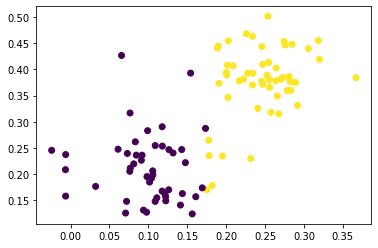

In [37]:
plot_data(X, our_preds)

In [38]:
test_preds = make_predictions(test_X, model_2, weights)

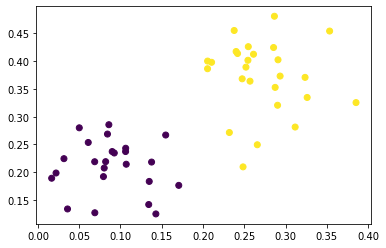

In [39]:
plot_data(test_X, test_preds)

In [40]:
compute_accuracy(test_y, test_preds)

0.98

### VQC model 3: multi-layer angle embedding

<img src="fig/model3.png" width="500px">

In [41]:
@qml.qnode(dev)
def model_3(point, weights):
    # Encoding
    qml.AngleEmbedding(point, wires=range(2))
    
    # Trainable layers
    qml.StronglyEntanglingLayers(weights, wires=range(2))
    
    # Measure
    return qml.expval(qml.PauliX(0))

In [42]:
weights = np.random.normal(size=(4, 2, 3))

In [43]:
weights

tensor([[[ 0.61263475, -0.16011878, -0.55439415],
         [ 0.96486688, -0.75336657, -1.33906347]],

        [[-0.96092065,  0.60391504,  1.52687598],
         [ 0.58617914, -0.10502404,  0.8152147 ]],

        [[ 0.49295243, -1.00487773, -1.10984192],
         [ 0.18279491,  0.6823054 ,  0.68758104]],

        [[ 2.03552828,  0.35968333, -1.26330061],
         [ 0.84981515,  0.07299835,  0.13312379]]], requires_grad=True)

In [44]:
our_preds = make_predictions(X, model_3, weights)

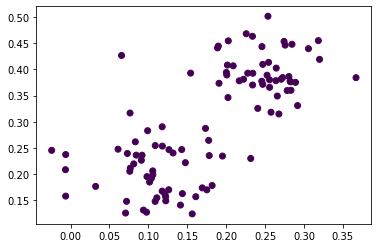

In [45]:
plot_data(X, our_preds)

In [47]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

loss = make_loss_function(X, y, model_3)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_3, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 0 = 1.5306296304001696  Accuracy = 0.5
Loss at iteration 5 = 1.2355087951167918  Accuracy = 0.19
Loss at iteration 10 = 1.202148070746105  Accuracy = 0.05
Loss at iteration 15 = 1.1783586344048782  Accuracy = 0.04
Loss at iteration 25 = 1.091604781198337  Accuracy = 0.15
Loss at iteration 30 = 1.030984000355837  Accuracy = 0.43
Loss at iteration 35 = 0.971494318363104  Accuracy = 0.66
Loss at iteration 40 = 0.924652589300595  Accuracy = 0.89
Loss at iteration 45 = 0.8923446625759791  Accuracy = 0.95
Loss at iteration 50 = 0.8700777174835014  Accuracy = 0.96
Loss at iteration 55 = 0.8536695872390768  Accuracy = 0.98
Loss at iteration 60 = 0.8407818470128902  Accuracy = 0.99
Loss at iteration 65 = 0.830279221359494  Accuracy = 0.99
Loss at iteration 70 = 0.8215933561426314  Accuracy = 0.99
Loss at iteration 75 = 0.8143901305532519  Accuracy = 0.99
Loss at iteration 80 = 0.8084297176425324  Accuracy = 0.99
Loss at iteration 85 = 0.8035158946803069  Accuracy = 0.99
Loss a

In [48]:
our_preds = make_predictions(X, model_3, weights)

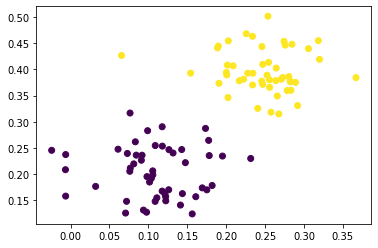

In [49]:
plot_data(X, our_preds)

In [50]:
test_preds = make_predictions(test_X, model_3, weights)

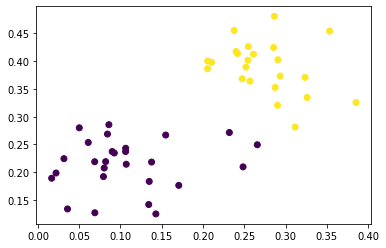

In [51]:
plot_data(test_X, test_preds)

In [52]:
compute_accuracy(test_y, test_preds)

0.96

## Demo 2: Hamiltonians

In [54]:
coeffs = [0.5, 1.5]
obs = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]

In [55]:
H = qml.Hamiltonian(coeffs, obs)

In [56]:
print(H)

  (0.5) [Z0 Z1]
+ (1.5) [X0 X1]


## Demo 3: Variational Quantum Eigensolver

<img src="fig/VQE-generic-ansatz.png">

<img src="fig/VQE-problem-specific-ansatz.png">

In [57]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def ansatz(theta):
    qml.RY(theta, wires=0)
    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.PauliX(wires=0)
    return qml.expval(H)

In [58]:
theta = np.array(0.3, requires_grad=True)

In [60]:
ansatz(theta)

tensor(-0.05671969, requires_grad=True)

In [64]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

costs = []

for _ in range(50):
    theta, _cost = opt.step_and_cost(ansatz, theta)
    costs.append(_cost)

In [65]:
theta

tensor(-1.57079607, requires_grad=True)

In [66]:
ansatz(theta)

tensor(-2., requires_grad=True)